#Hard reset & GoogleAuth

In [0]:
!kill -9 -1

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Database download

In [17]:
!git clone --recursive https://github.com/2014mchidamb/DeepColorization.git
!git clone --recursive https://github.com/Kernev/Elmer-1.git

fatal: destination path 'DeepColorization' already exists and is not an empty directory.
Cloning into 'Elmer-1'...
remote: Counting objects: 13311, done.
remote: Total 13311 (delta 0), reused 0 (delta 0), pack-reused 13311
Receiving objects: 100% (13311/13311), 179.73 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (15/15), done.


# ELMER-0.1.1 Entrainement sur dataset via github

##GPU actif ?

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import time
import random
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Get images
X = []
for i,filename in enumerate(os.listdir('DeepColorization/face_images')):
    X.append(img_to_array(load_img('DeepColorization/face_images/'+filename)))
    #if i is 2: break
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.80*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [33]:
#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 32)    9248      
__________

In [0]:
# Finish model
model.compile(optimizer='rmsprop', loss='mse')

In [0]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 1
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [36]:
# Train model
TensorBoard(log_dir='/output')
start_time = time.time()
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=100, epochs=50)
print("EXECUTION TIME: %s s" % (time.time() - start_time))

Epoch 1/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0051
Epoch 2/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0031
Epoch 3/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0020
Epoch 4/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 5/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0020
Epoch 6/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0018
Epoch 7/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0018
Epoch 8/50
 56/100 [===============>..............] - ETA: 0s - loss: 0.0017

100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 9/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0017
Epoch 10/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 11/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 12/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 13/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 14/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 15/50
 78/100 [======================>.......] - ETA: 0s - loss: 0.0014

100/100 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 16/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 17/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 18/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 19/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 20/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 21/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 22/50
 73/100 [====================>.........] - ETA: 0s - loss: 0.0016

100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 23/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0017
Epoch 24/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 25/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0018
Epoch 26/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 27/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 28/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 29/50
 74/100 [=====================>........] - ETA: 0s - loss: 0.0014

100/100 [==============================] - 2s 22ms/step - loss: 0.0014
Epoch 30/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0014
Epoch 31/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 32/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 33/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 34/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 35/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 36/50
 70/100 [====================>.........] - ETA: 0s - loss: 0.0013

100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 37/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0016
Epoch 38/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0016
Epoch 39/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0013
Epoch 40/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0016
Epoch 41/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0013
Epoch 42/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0014
Epoch 43/50
 81/100 [=======================>......] - ETA: 0s - loss: 0.0014

100/100 [==============================] - 2s 23ms/step - loss: 0.0014
Epoch 44/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 45/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0013
Epoch 46/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 47/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 48/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0015
Epoch 49/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0015
Epoch 50/50
 75/100 [=====================>........] - ETA: 0s - loss: 0.0016

100/100 [==============================] - 2s 23ms/step - loss: 0.0016
EXECUTION TIME: 112.59264469146729 s


In [37]:
# Test images
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print (model.evaluate(Xtest, Ytest, batch_size=batch_size))

150/150 [==============================] - 1s 5ms/step
0.0012377171528836091


In [0]:
# Load tests and white images
color_me = []
for i in range(split, 750):
        color_me.append(img_to_array(load_img('DeepColorization/face_images/image00'+ str(i) + '.jpg')))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [0]:
# Test model
output = model.predict(color_me)
output = output * 128

FICHIER: Elmer-1/Datasets/Results/img_0.png


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


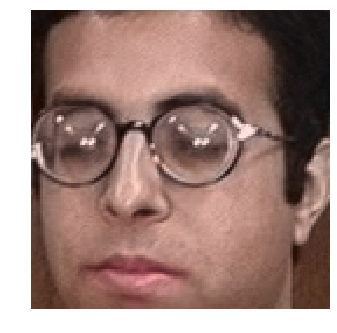

Ground Truth


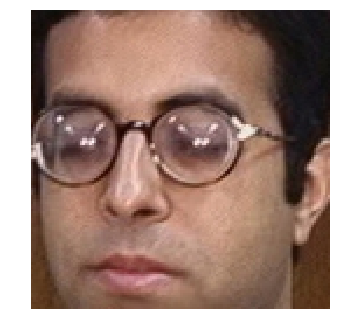





FICHIER: Elmer-1/Datasets/Results/img_1.png


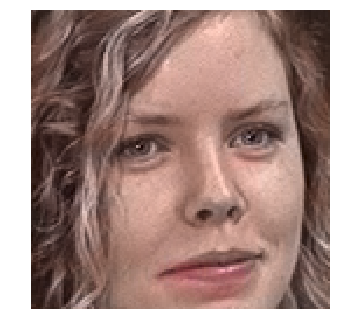

Ground Truth


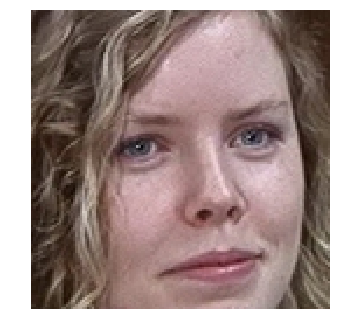





FICHIER: Elmer-1/Datasets/Results/img_2.png


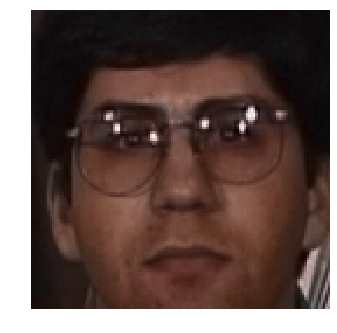

Ground Truth


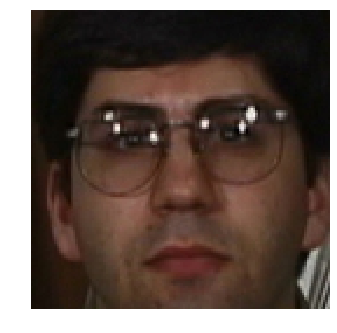





FICHIER: Elmer-1/Datasets/Results/img_3.png


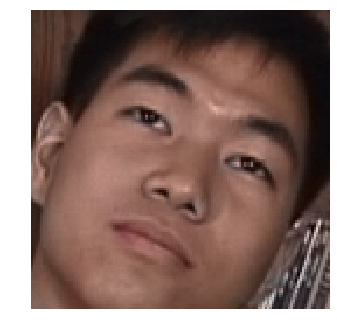

Ground Truth


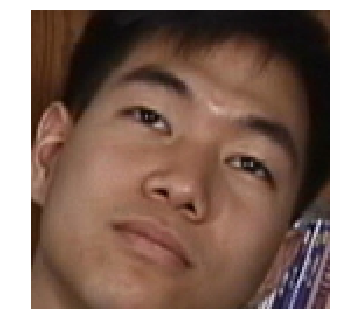





FICHIER: Elmer-1/Datasets/Results/img_4.png


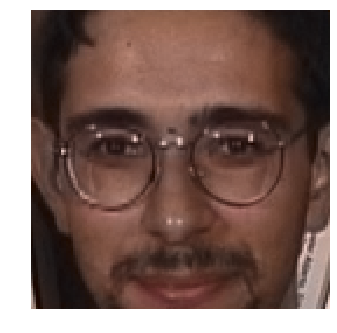

Ground Truth


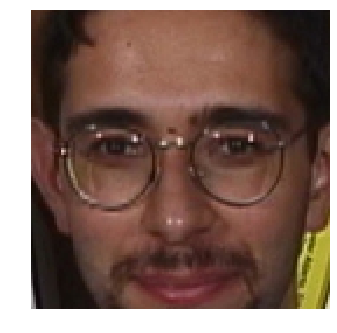





FICHIER: Elmer-1/Datasets/Results/img_5.png


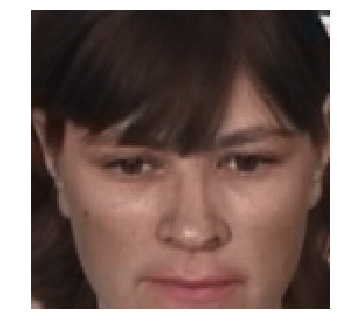

Ground Truth


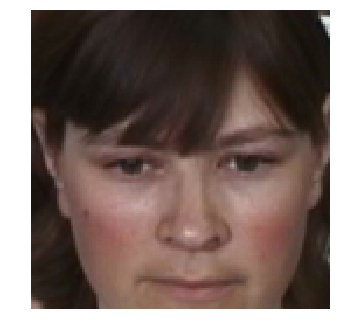





FICHIER: Elmer-1/Datasets/Results/img_6.png


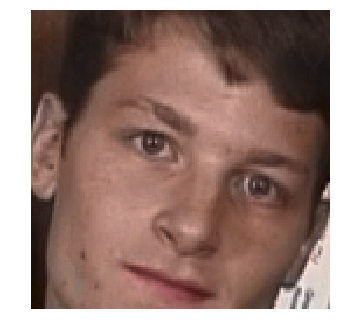

Ground Truth


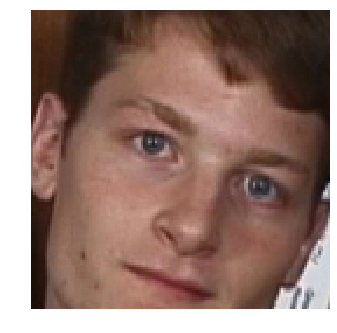





FICHIER: Elmer-1/Datasets/Results/img_7.png


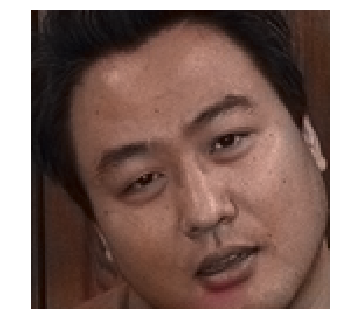

Ground Truth


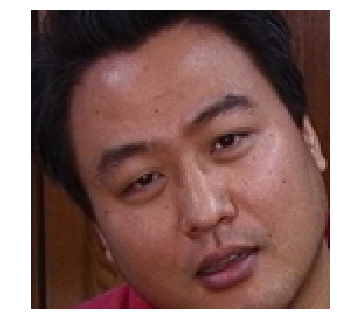





FICHIER: Elmer-1/Datasets/Results/img_8.png


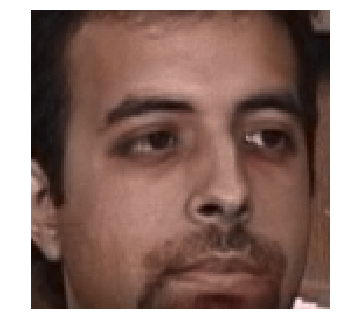

Ground Truth


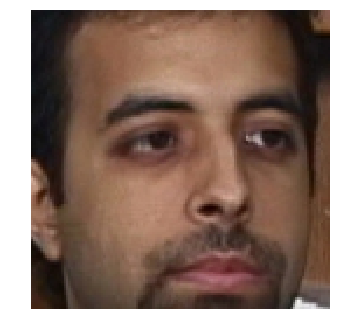





FICHIER: Elmer-1/Datasets/Results/img_9.png


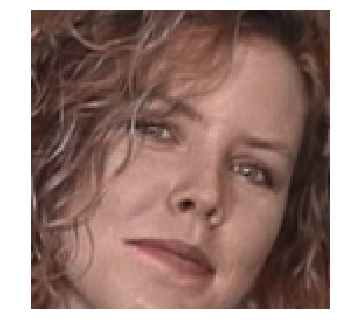

Ground Truth


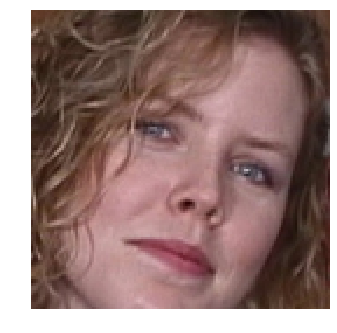





FICHIER: Elmer-1/Datasets/Results/img_10.png


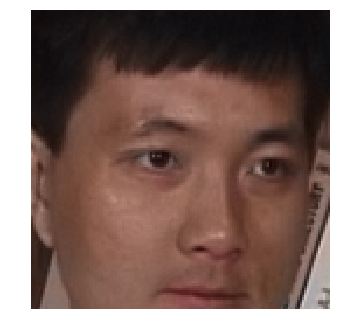

Ground Truth


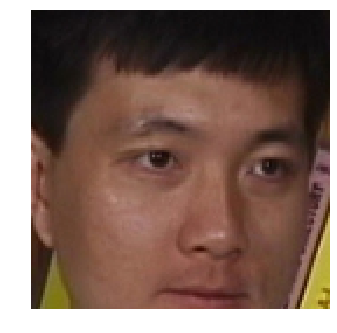





FICHIER: Elmer-1/Datasets/Results/img_11.png


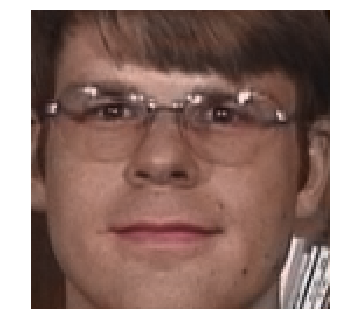

Ground Truth


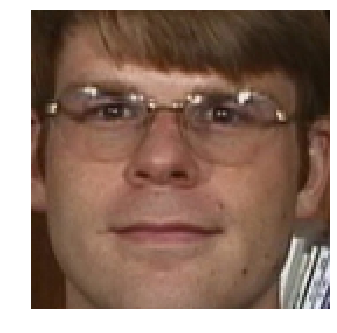





FICHIER: Elmer-1/Datasets/Results/img_12.png


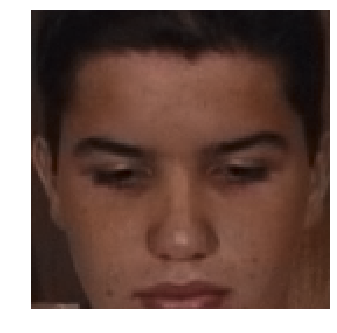

Ground Truth


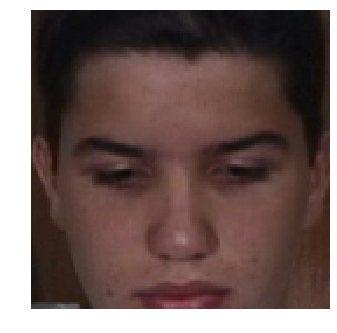





FICHIER: Elmer-1/Datasets/Results/img_13.png


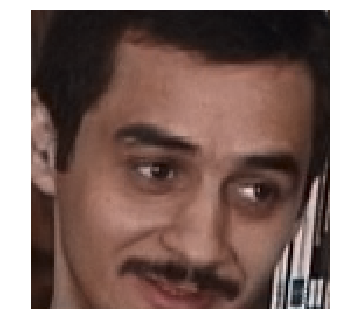

Ground Truth


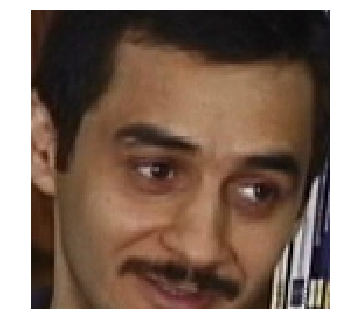





FICHIER: Elmer-1/Datasets/Results/img_14.png


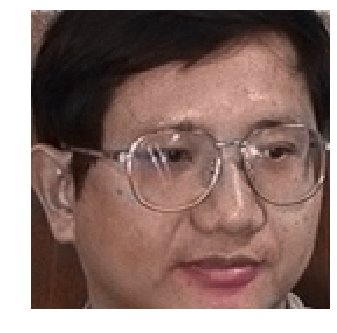

Ground Truth


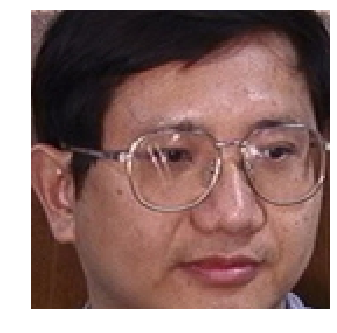





FICHIER: Elmer-1/Datasets/Results/img_15.png


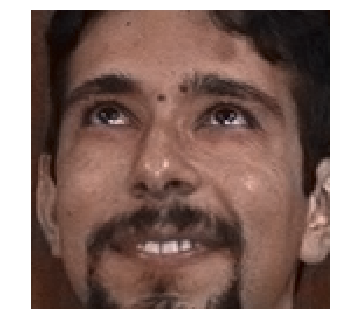

Ground Truth


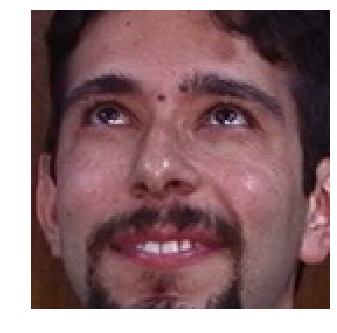





FICHIER: Elmer-1/Datasets/Results/img_16.png


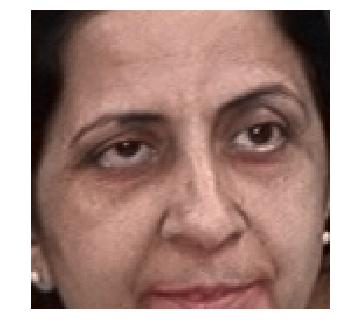

Ground Truth


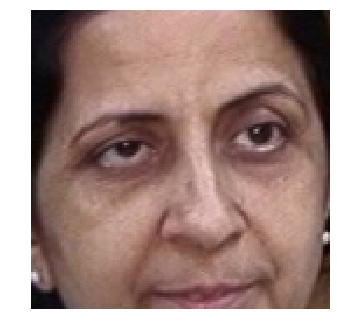





FICHIER: Elmer-1/Datasets/Results/img_17.png


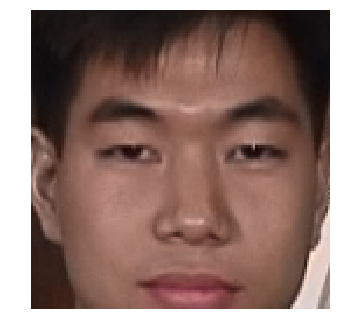

Ground Truth


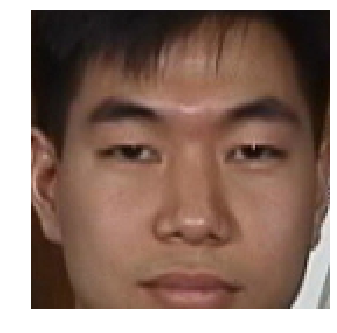





FICHIER: Elmer-1/Datasets/Results/img_18.png


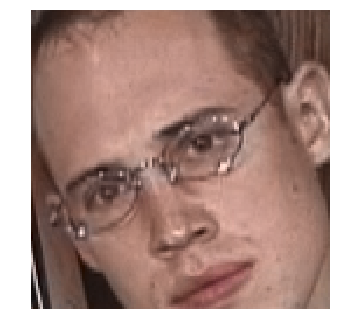

Ground Truth


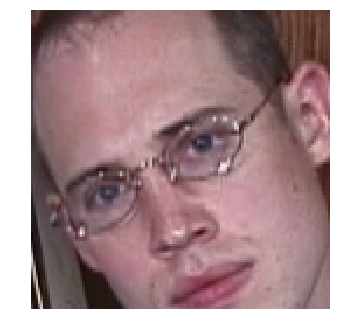





FICHIER: Elmer-1/Datasets/Results/img_19.png


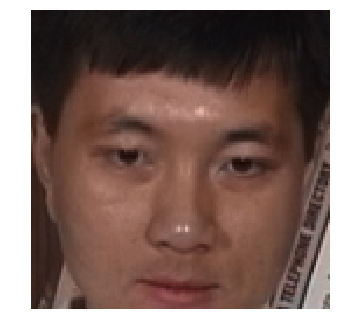

Ground Truth


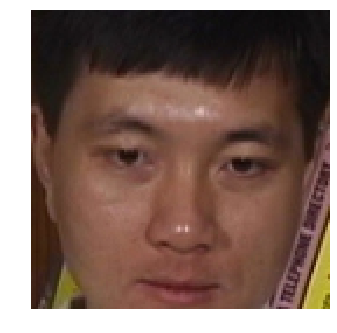





FICHIER: Elmer-1/Datasets/Results/img_20.png


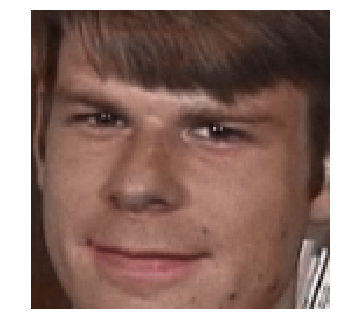

Ground Truth


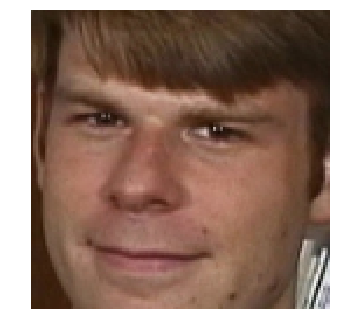





FICHIER: Elmer-1/Datasets/Results/img_21.png


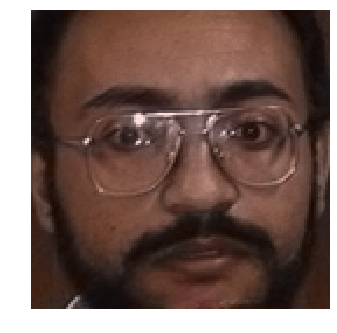

Ground Truth


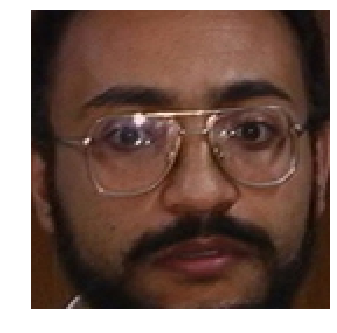





FICHIER: Elmer-1/Datasets/Results/img_22.png


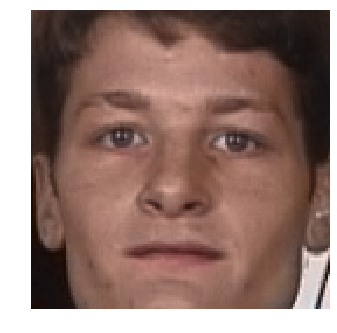

Ground Truth


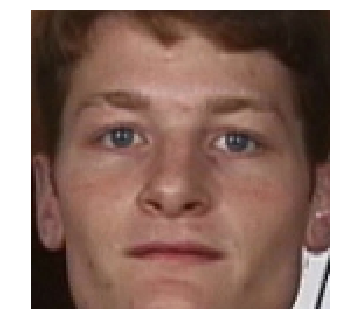





FICHIER: Elmer-1/Datasets/Results/img_23.png


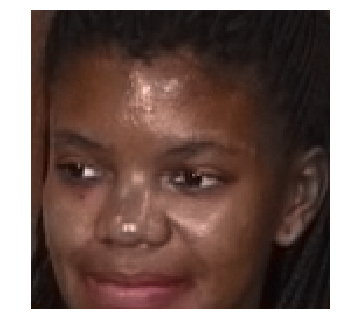

Ground Truth


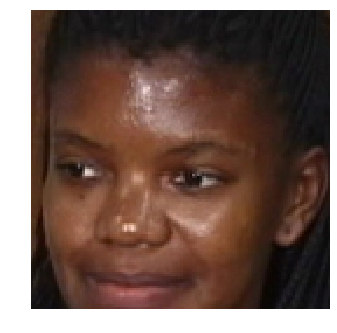





FICHIER: Elmer-1/Datasets/Results/img_24.png


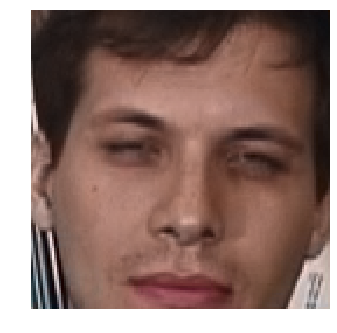

Ground Truth


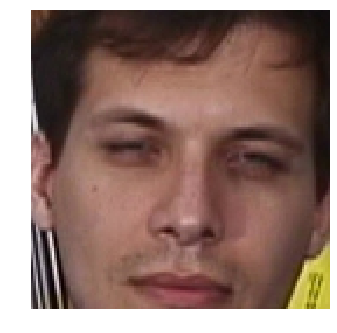





FICHIER: Elmer-1/Datasets/Results/img_25.png


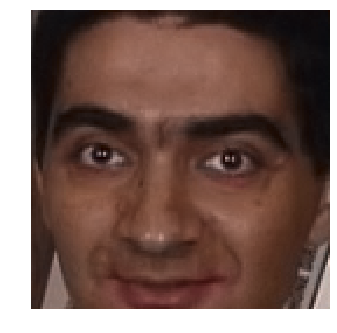

Ground Truth


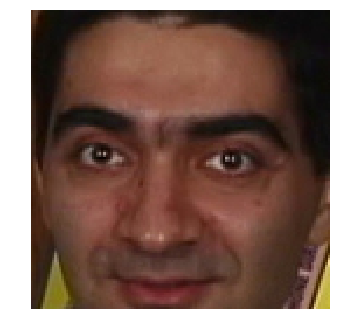





FICHIER: Elmer-1/Datasets/Results/img_26.png


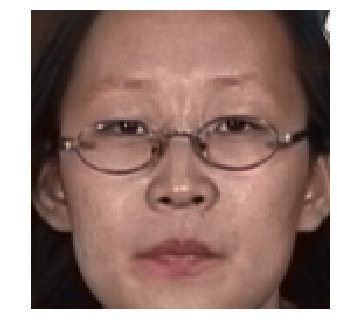

Ground Truth


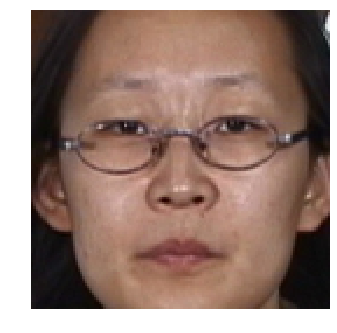





FICHIER: Elmer-1/Datasets/Results/img_27.png


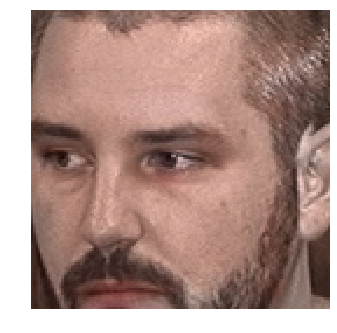

Ground Truth


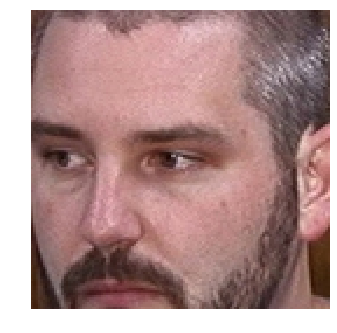





FICHIER: Elmer-1/Datasets/Results/img_28.png


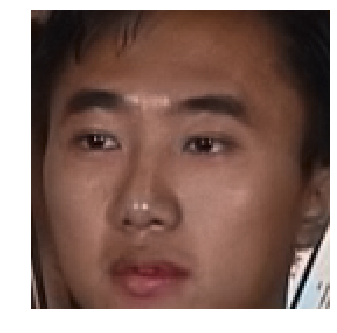

Ground Truth


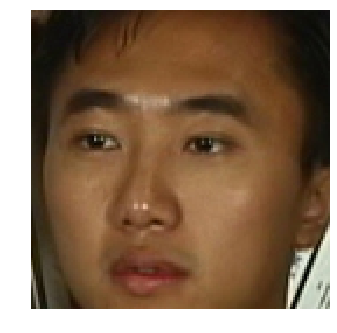





FICHIER: Elmer-1/Datasets/Results/img_29.png


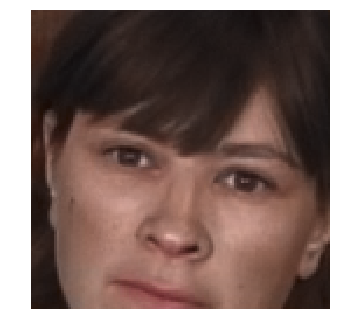

Ground Truth


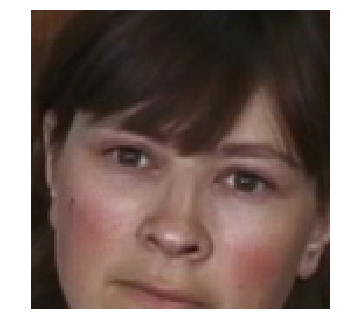





FICHIER: Elmer-1/Datasets/Results/img_30.png


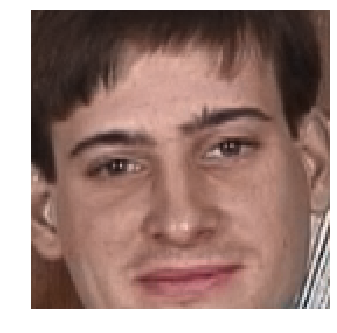

Ground Truth


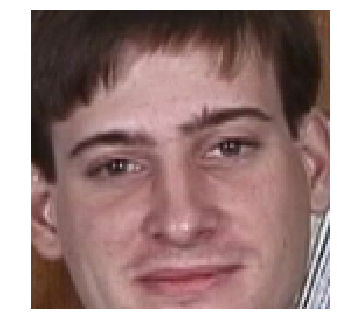





FICHIER: Elmer-1/Datasets/Results/img_31.png


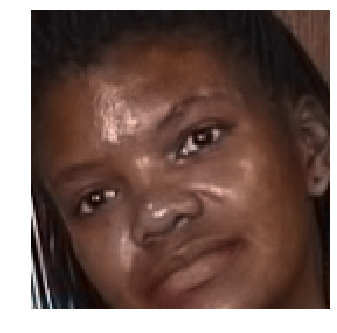

Ground Truth


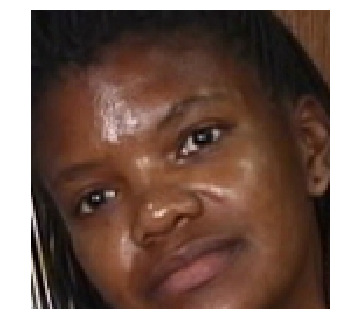





FICHIER: Elmer-1/Datasets/Results/img_32.png


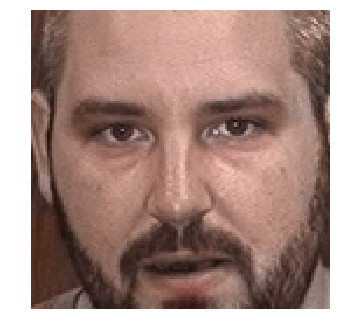

Ground Truth


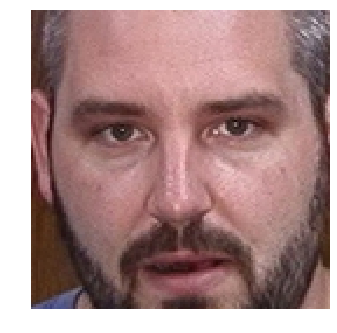





FICHIER: Elmer-1/Datasets/Results/img_33.png


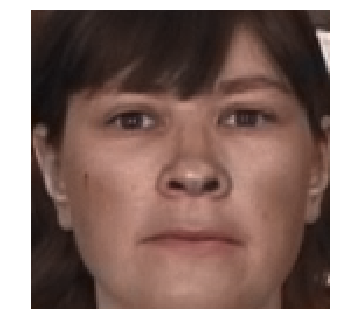

Ground Truth


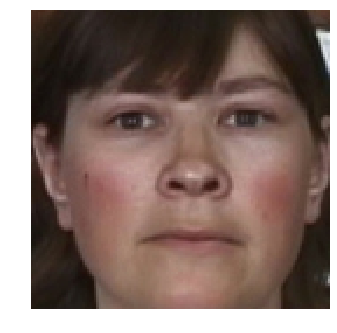





FICHIER: Elmer-1/Datasets/Results/img_34.png


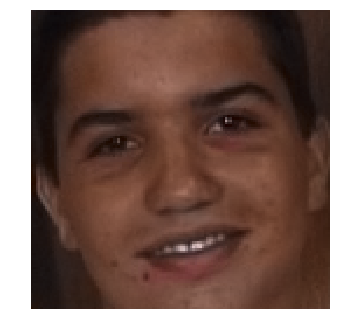

Ground Truth


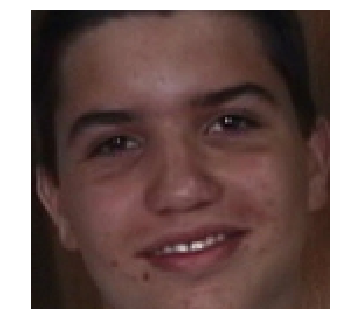





FICHIER: Elmer-1/Datasets/Results/img_35.png


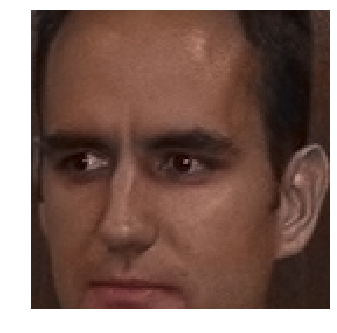

Ground Truth


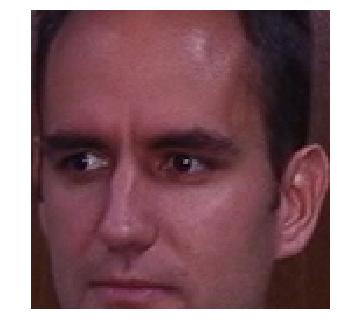





FICHIER: Elmer-1/Datasets/Results/img_36.png


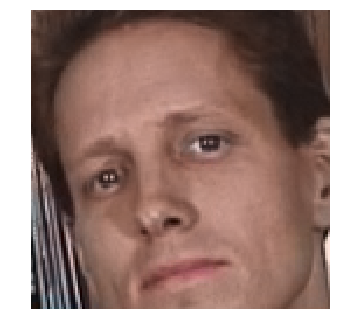

Ground Truth


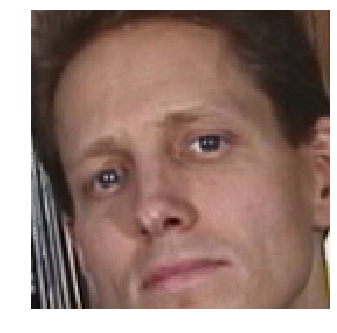





FICHIER: Elmer-1/Datasets/Results/img_37.png


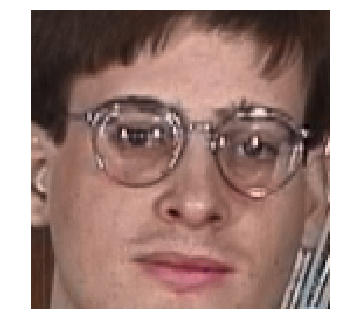

Ground Truth


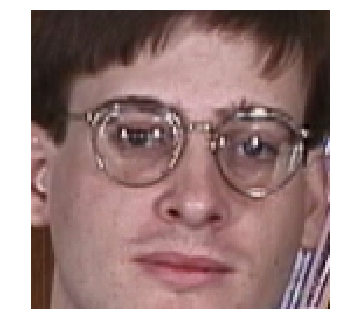





FICHIER: Elmer-1/Datasets/Results/img_38.png


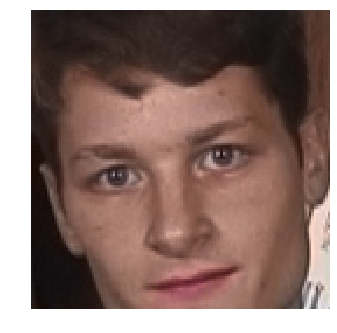

Ground Truth


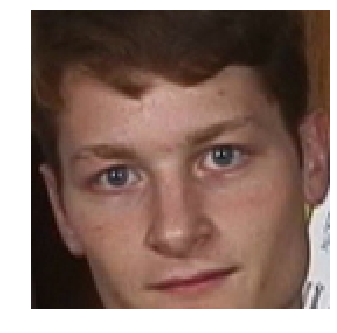





FICHIER: Elmer-1/Datasets/Results/img_39.png


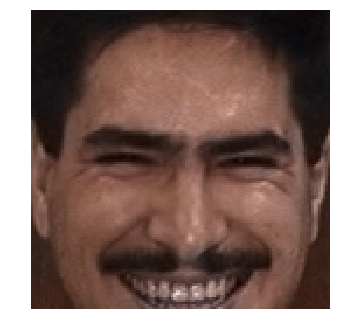

Ground Truth


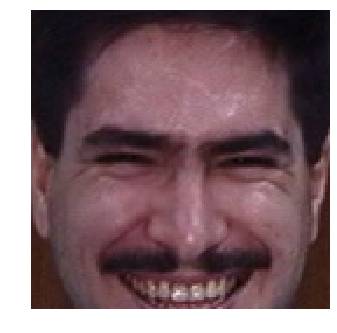





FICHIER: Elmer-1/Datasets/Results/img_40.png


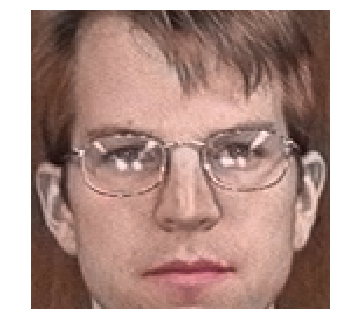

Ground Truth


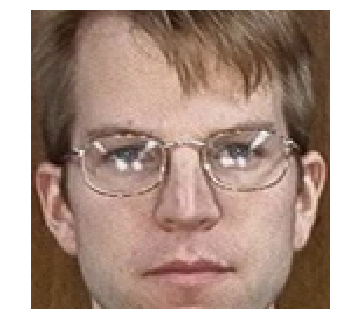





FICHIER: Elmer-1/Datasets/Results/img_41.png


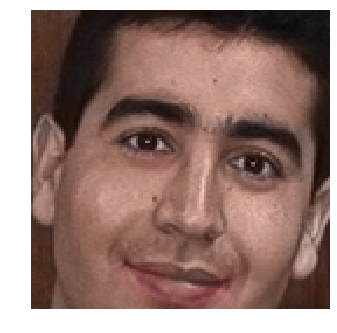

Ground Truth


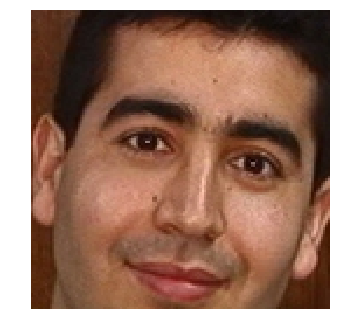





FICHIER: Elmer-1/Datasets/Results/img_42.png


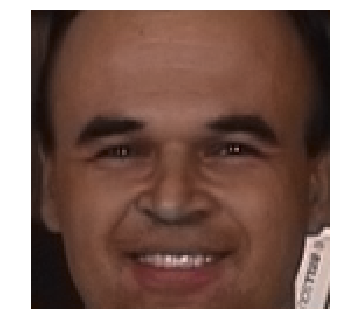

Ground Truth


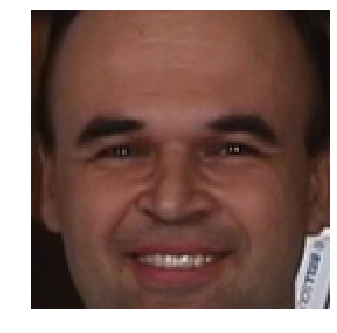





FICHIER: Elmer-1/Datasets/Results/img_43.png


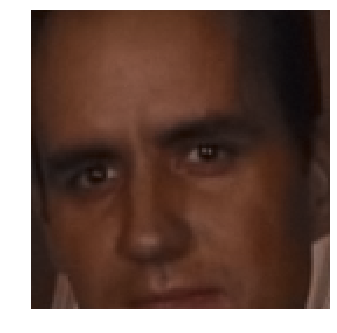

Ground Truth


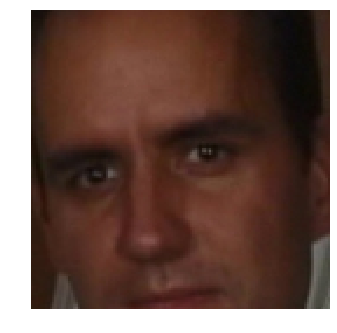





FICHIER: Elmer-1/Datasets/Results/img_44.png


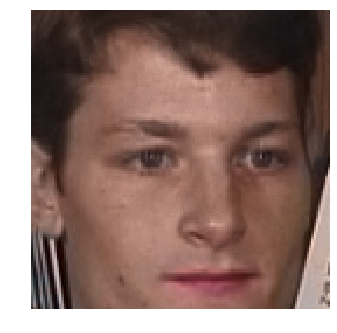

Ground Truth


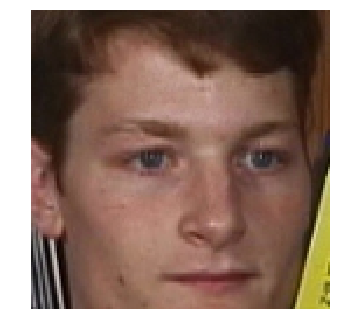





FICHIER: Elmer-1/Datasets/Results/img_45.png


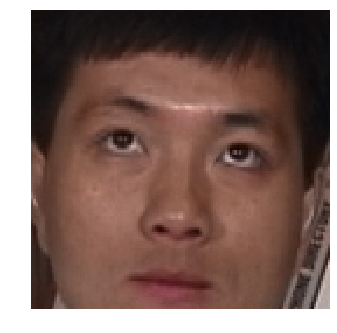

Ground Truth


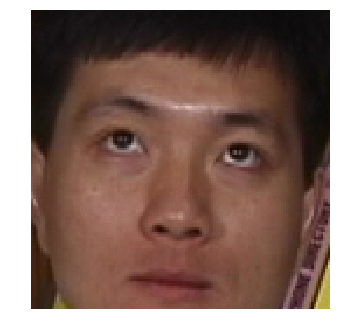





FICHIER: Elmer-1/Datasets/Results/img_46.png


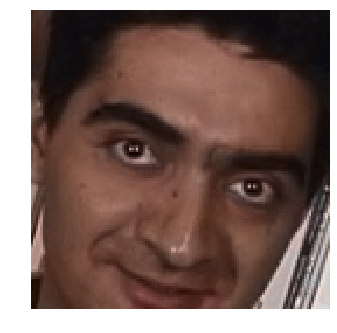

Ground Truth


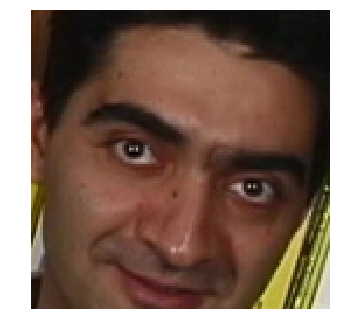





FICHIER: Elmer-1/Datasets/Results/img_47.png


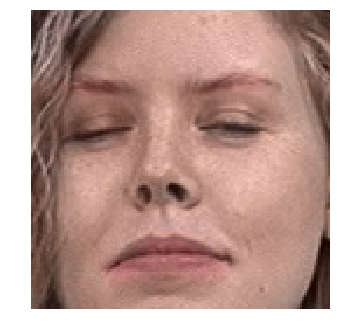

Ground Truth


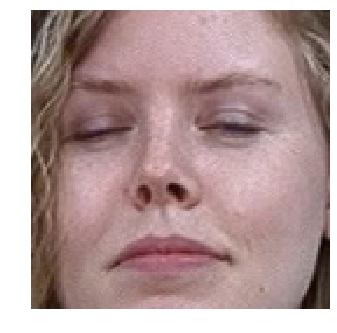





FICHIER: Elmer-1/Datasets/Results/img_48.png


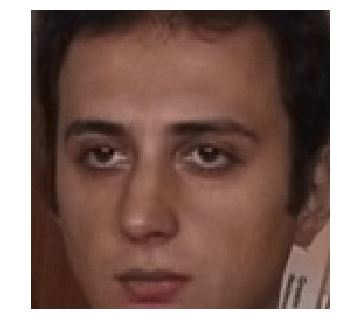

Ground Truth


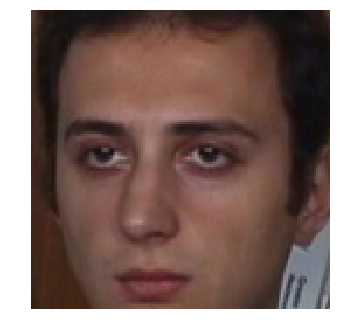





FICHIER: Elmer-1/Datasets/Results/img_49.png


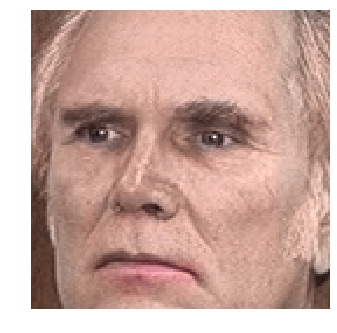

Ground Truth


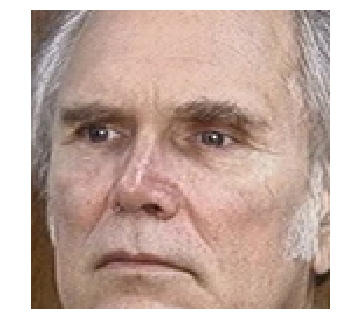





FICHIER: Elmer-1/Datasets/Results/img_50.png


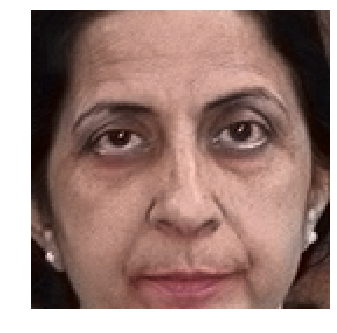

Ground Truth


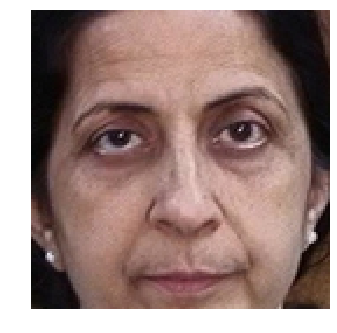





FICHIER: Elmer-1/Datasets/Results/img_51.png


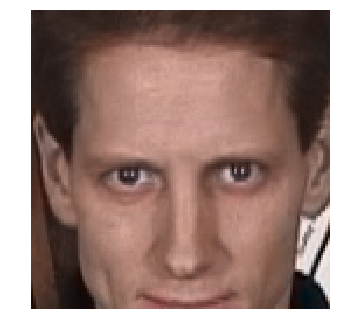

Ground Truth


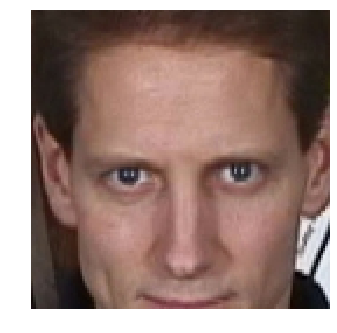





FICHIER: Elmer-1/Datasets/Results/img_52.png


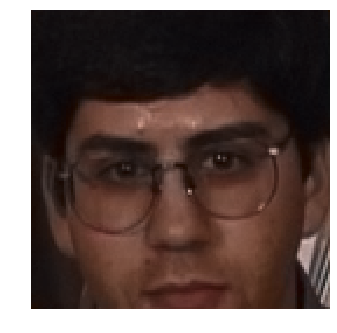

Ground Truth


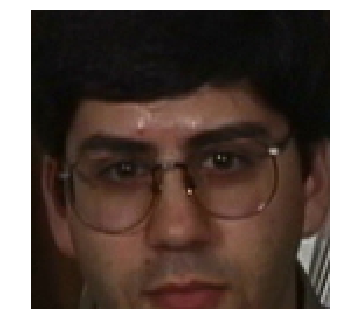





FICHIER: Elmer-1/Datasets/Results/img_53.png


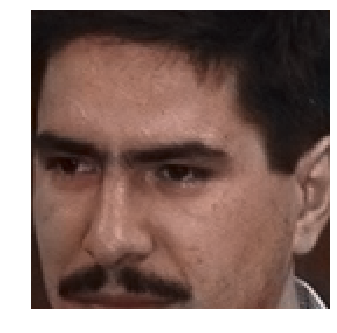

Ground Truth


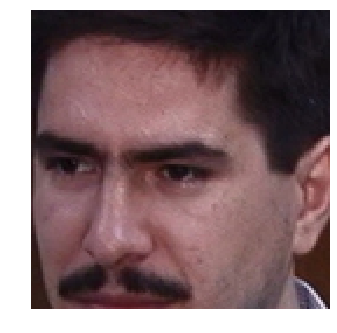





FICHIER: Elmer-1/Datasets/Results/img_54.png


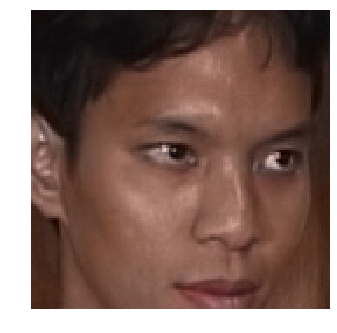

Ground Truth


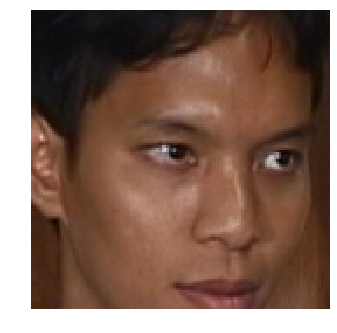





FICHIER: Elmer-1/Datasets/Results/img_55.png


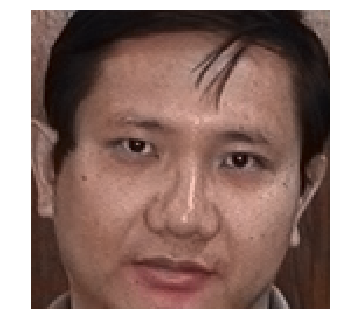

Ground Truth


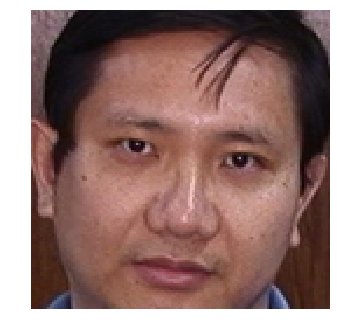





FICHIER: Elmer-1/Datasets/Results/img_56.png


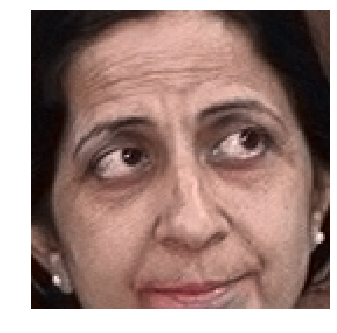

Ground Truth


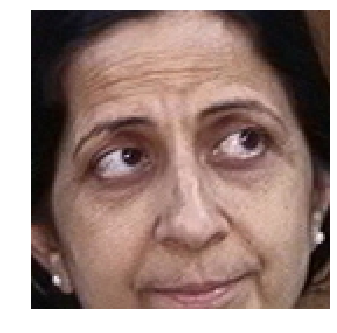





FICHIER: Elmer-1/Datasets/Results/img_57.png


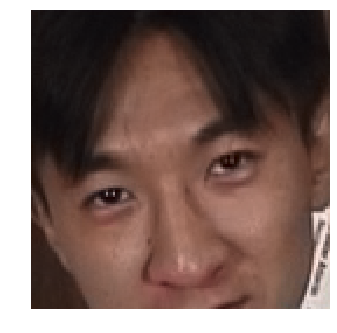

Ground Truth


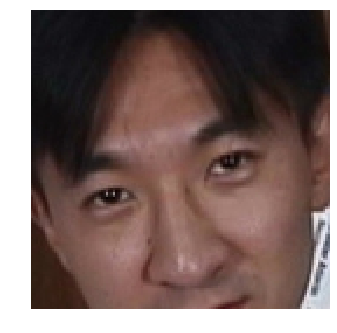





FICHIER: Elmer-1/Datasets/Results/img_58.png


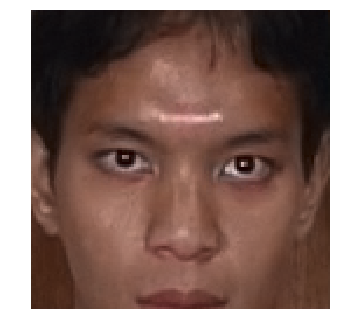

Ground Truth


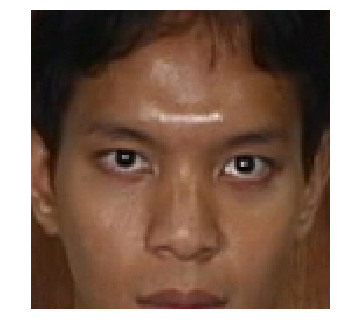





FICHIER: Elmer-1/Datasets/Results/img_59.png


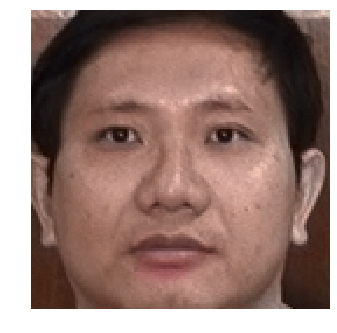

Ground Truth


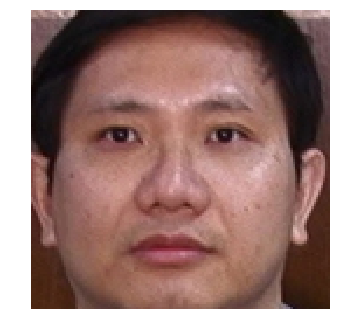





FICHIER: Elmer-1/Datasets/Results/img_60.png


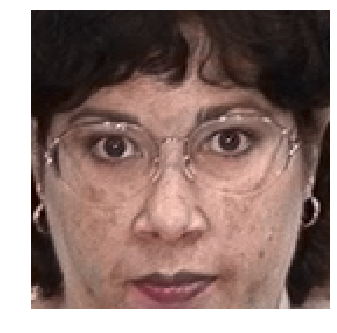

Ground Truth


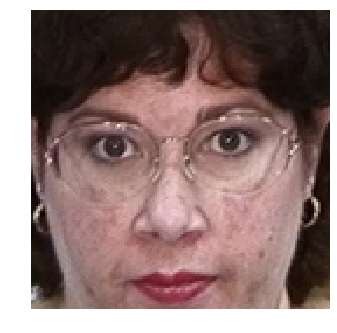





FICHIER: Elmer-1/Datasets/Results/img_61.png


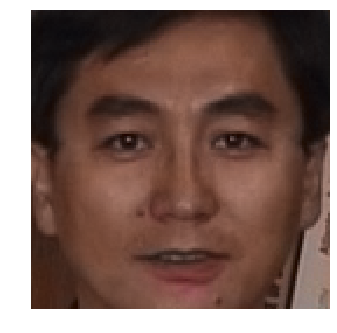

Ground Truth


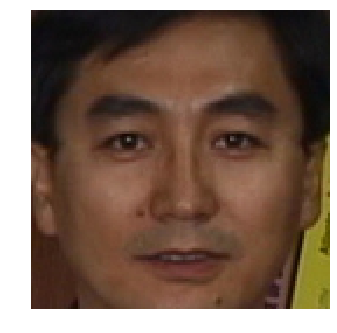





FICHIER: Elmer-1/Datasets/Results/img_62.png


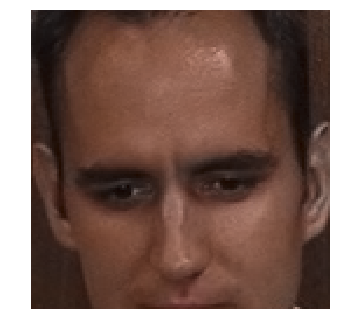

Ground Truth


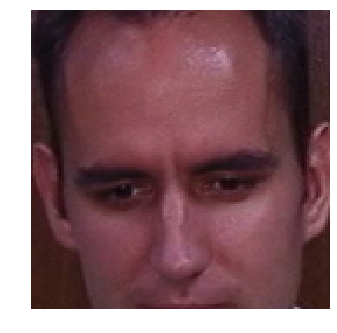





FICHIER: Elmer-1/Datasets/Results/img_63.png


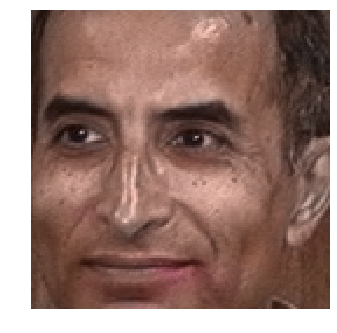

Ground Truth


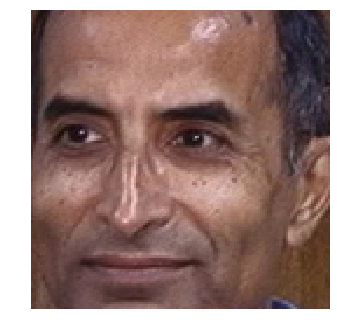





FICHIER: Elmer-1/Datasets/Results/img_64.png


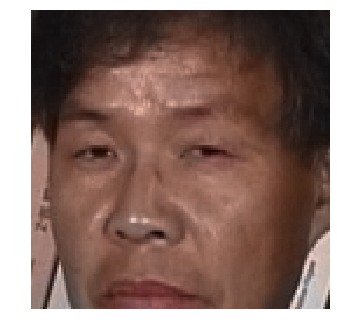

Ground Truth


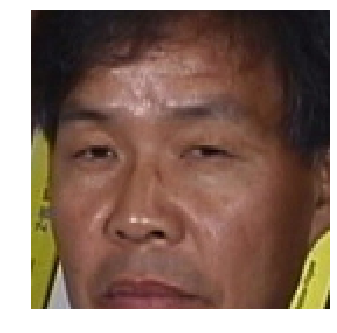





FICHIER: Elmer-1/Datasets/Results/img_65.png


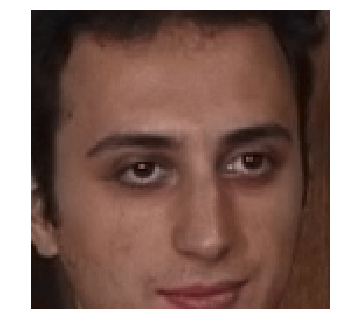

Ground Truth


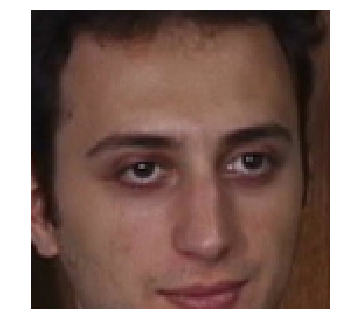





FICHIER: Elmer-1/Datasets/Results/img_66.png


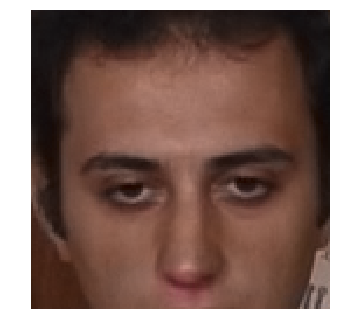

Ground Truth


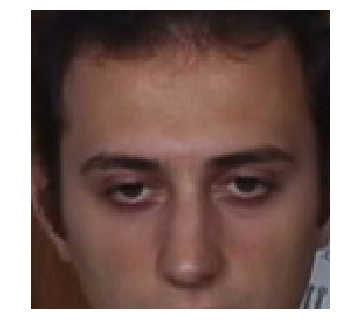





FICHIER: Elmer-1/Datasets/Results/img_67.png


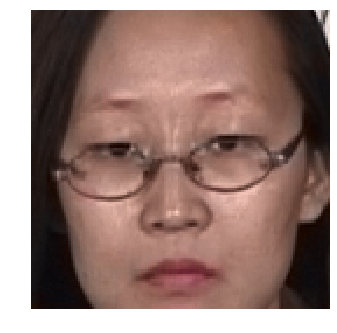

Ground Truth


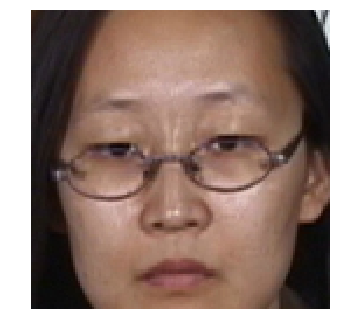





FICHIER: Elmer-1/Datasets/Results/img_68.png


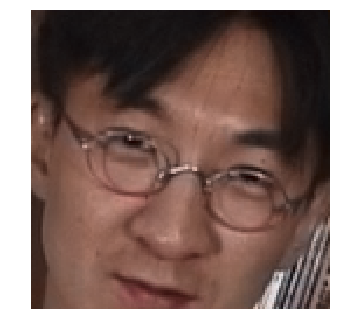

Ground Truth


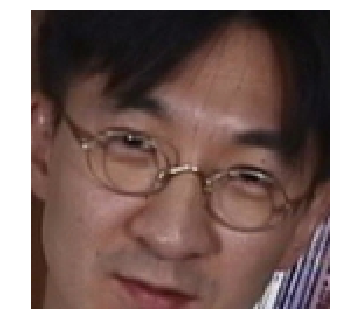





FICHIER: Elmer-1/Datasets/Results/img_69.png


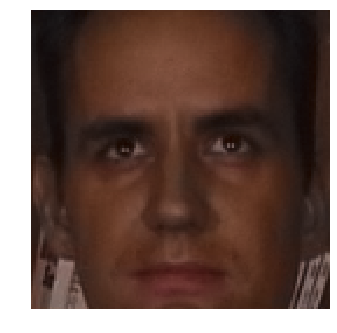

Ground Truth


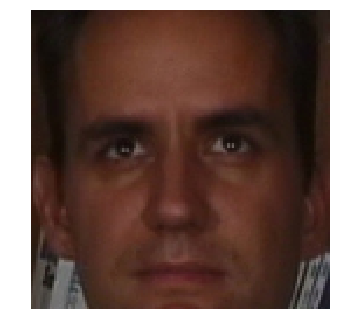





FICHIER: Elmer-1/Datasets/Results/img_70.png


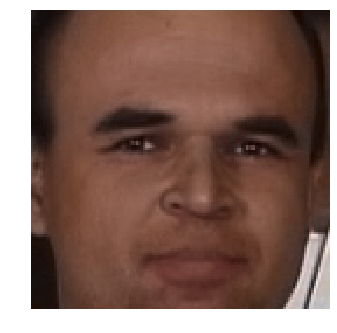

Ground Truth


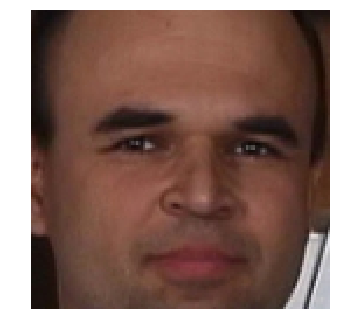





FICHIER: Elmer-1/Datasets/Results/img_71.png


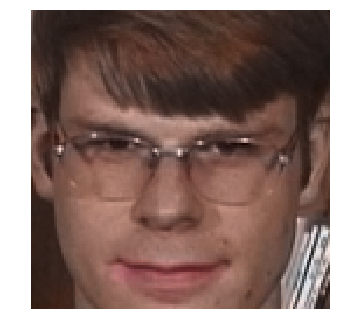

Ground Truth


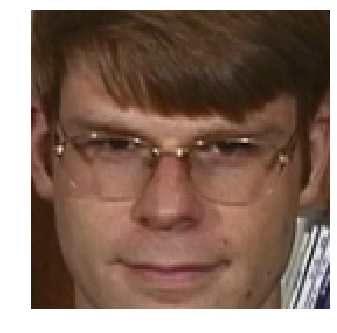





FICHIER: Elmer-1/Datasets/Results/img_72.png


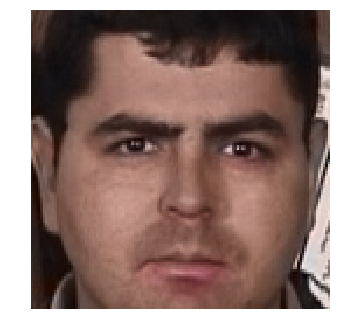

Ground Truth


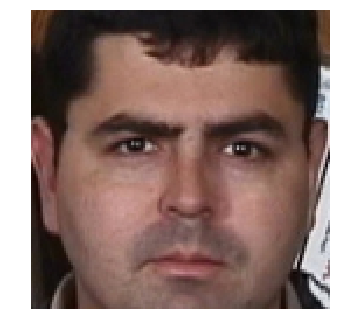





FICHIER: Elmer-1/Datasets/Results/img_73.png


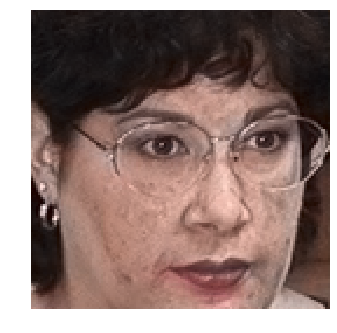

Ground Truth


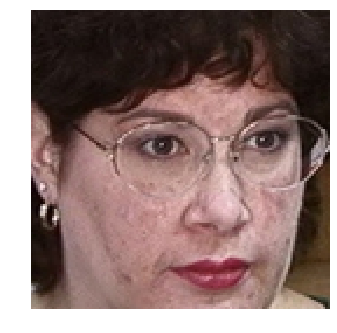





FICHIER: Elmer-1/Datasets/Results/img_74.png


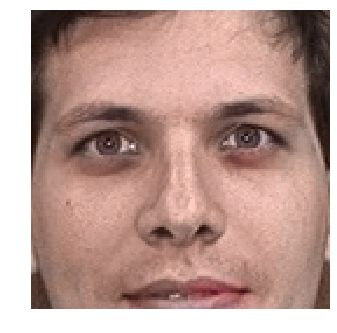

Ground Truth


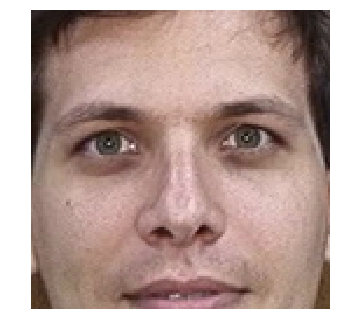





FICHIER: Elmer-1/Datasets/Results/img_75.png


KeyboardInterrupt: ignored

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Output colorizations
for i in range(len(output)):
        cur = np.zeros((128, 128, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("Elmer-1/Datasets/Results/img_"+str(i)+".png", lab2rgb(cur))
        image = mpimg.imread("Elmer-1/Datasets/Results/img_"+str(i)+".png")
        print("FICHIER:", "Elmer-1/Datasets/Results/img_"+str(i)+".png")
        plt.imshow(image)
        plt.axis('off')
        plt.grid(False)
        plt.show()
        
        ground_truth = mpimg.imread("DeepColorization/face_images/image00"+str(i+split)+".jpg")
        print("Ground Truth")
        plt.imshow(ground_truth)
        plt.axis('off')
        plt.grid(False)
        plt.show()

        print("\n\n\n")


#Test sur un ficheir perso HxH

In [45]:
!rm igor.jpg
from google.colab import files
files.upload()

rm: cannot remove 'igor.jpg': No such file or directory


Saving 13223.jpg to 13223.jpg


{'13223.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x00\xfa\x00\xfa\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\

In [53]:
color_me = []
color_me.append(img_to_array(load_img('13223.jpg')))
color_me = np.array(color_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Output colorizations
cur = np.zeros((250, 250, 3))
cur[:,:,0] = color_me[0][:,:,0]
cur[:,:,1:] = output[0]
imsave("Elmer-1/Datasets/Results/img_"+str(i)+".png", lab2rgb(cur))
image = mpimg.imread("Elmer-1/Datasets/Results/img_"+str(i)+".png")
print("FICHIER:", "Elmer-1/Datasets/Results/img_"+str(i)+".png")
plt.imshow(image)
plt.axis('off')
plt.grid(False)
plt.show()

ValueError: ignored

#Enregistrement du fichier
(Situé dans les fichiers récents. Je sais pas faire autrement)

In [43]:
file5 = drive.CreateFile()

# Read file and set it as a content of this instance.
file5.SetContentFile('Elmer-1/Datasets/Results/img_2.png')
file5.Upload() # Upload the file.
print('title: %s, mimeType: %s' % (file5['title'], file5['mimeType']))
# title: cat.png, mimeType: image/png

NameError: ignored